# Utilities for data 

> This module handles all communication-related functionalities, including message passing, event handling, and notifications.

In [ ]:
#| default_exp data.utils

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from fastcore import *
from fastcore.utils import *

### Transforms

In [ ]:
#| export
import torch
from torchvision.transforms import v2
base_tf = v2.Compose([
    v2.ToPILImage(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

denormalize_tf = v2.Compose([
    v2.Normalize(mean=[0., 0., 0.], std=[1/0.5, 1/0.5, 1/0.5]),
    v2.Normalize(mean=[-0.5, -0.5, -0.5], std=[1., 1., 1.]),
])

In [ ]:
#| export
import torch
from torchvision.transforms import v2
lejepa_train_tf = v2.Compose(
    [
        v2.ToPILImage(),
        v2.RandomResizedCrop(42, scale=(0.8, 1.0)), 
        v2.RandomApply([v2.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
        v2.RandomGrayscale(p=0.2),
        v2.RandomApply([v2.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))], p=0.1),
        v2.RandomHorizontalFlip(),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)


lejepa_test_tf = v2.Compose(
            [
                v2.ToPILImage(),
                v2.Resize(42),
                v2.CenterCrop(42),
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            ]
        )

### Message creation as a transform

#### Using Graphics Primitives

In [ ]:
#| export
import cv2
import numpy as np
import torch
def get_graphics_primitives(img_np):
    img = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
    pixels = img.reshape(-1, 3)
    colors = np.unique(pixels, axis=0)

    primitives = []
    background_color = np.array([0, 0, 0])  # assuming black background
    for color in colors:
        if np.all(color == background_color):
            continue

        mask = cv2.inRange(img, color, color)
        contours, _ = cv2.findContours(
            mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            primitives.append((color, x, y, w, h))
            
    return primitives

In [ ]:
#| hide
import matplotlib.pyplot as plt
def plot_img_with_primitives(obs, primitives):
    
    fig, ax = plt.subplots(1)
    ax.imshow(obs)
    for primitive in primitives:
        color, x1, y1, w, h = primitive
        x2, y2 = x1 + w, y1 + h
        
        ax.add_patch(plt.Rectangle((x1, y1), w, h, edgecolor='r', facecolor='none', linewidth=2))
        rgb_color = (color[2]/255, color[1]/255, color[0]/255)
    # ax.plot((x1, x2), (y1, y2), '-r', linewidth=2)

In [ ]:
#| export
import cv2
import matplotlib.pyplot as plt
def show_grid(img, GRID = 7, CELL = 6):
    if not CELL:
        CELL = img.shape[0] // GRID
    
    vis = img.copy()
    vis = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)
    for i in range(1, GRID):
        cv2.line(vis, (i*CELL, 0), (i*CELL, 42), (255,255,255), 1)
        cv2.line(vis, (0, i*CELL), (42, i*CELL), (255,255,255), 1)
    plt.imshow(vis, interpolation="nearest")
    plt.axis("off")

    return vis


#### Parsing Color info only

In [ ]:
#| export

def get_cell_color(cell):
    np_to_tuple = lambda arr: tuple(int(x) for x in arr)
    pixels = cell.reshape(-1, 3)
    colors, counts = np.unique(pixels, axis=0, return_counts=True)
    
    if len(colors) == 1:
        if np_to_tuple(colors[0]) in [(0, 255, 0)]:
            return "G" #"Goal"
        elif np_to_tuple(colors[0]) in [(74, 65, 42)]:
            return "W" #"Wall"
        else:
            return "E" #"Empty"
        
    else:
        
        for color in colors:
            if np_to_tuple(color) in [(198, 0, 0), (28, 0, 0), (255, 0, 0)]:
                color = (255, 0, 0)
                return "R" #"RedAgent"
            elif np_to_tuple(color) in [(0, 0, 198), (0, 0, 255)]:
                color = (0, 0, 255)
                return "B" #"BlueAgent"
                
    

In [ ]:
# | export
def get_grid_chars(img, GRID=7, CELL=6): #cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cells = [[img[j*CELL:(j+1)*CELL, i*CELL:(i+1)*CELL]
              for i in range(GRID)]
              for j in range(GRID)
            ]
    
    grid = np.zeros((GRID,GRID), dtype=object)
    for r in range(GRID):
        for c in range(GRID):
            color = get_cell_color(cells[r][c])
            grid[r][c] = color
    return grid

In [ ]:
#| export
import torch.nn.functional as F
import torch
def generate_msg(img):
    grid = get_grid_chars(img)
    grid[3,3] = 'R' # Agent's own position
    one_hot_msg = F.one_hot(torch.tensor([[{'E':0,'W':1,'G':2,'R':3,'B':4}[char] for char in row] for row in grid]), num_classes=5)
    return one_hot_msg



In [ ]:
#| hide
import torch.nn.functional as F
import torch
grid = torch.randint(0, 3, (7, 7))

num_primitives = 5
semantic_one_hot = F.one_hot(grid, num_classes=num_primitives)

In [ ]:
#| hide
semantic_one_hot.shape

torch.Size([7, 7, 5])

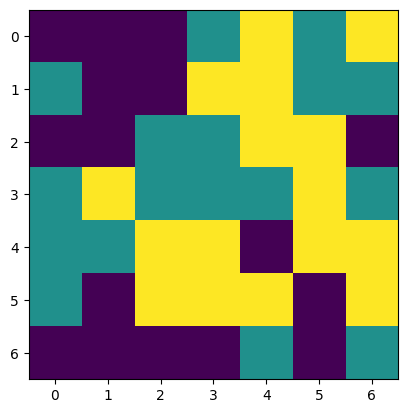

In [ ]:
#| hide
import matplotlib.pyplot as plt
plt.imshow(semantic_one_hot.numpy().argmax(axis=-1), cmap='viridis')
plt.show()


### Data Loading

In [ ]:
#| export
import torch

from mawm.data.loaders import MarlGridDataset
def init_data(cfg):
    train_ds = MarlGridDataset(
        data_path = cfg.data.data_dir,
        num_agents= len(cfg.env.agents),
        seq_len= cfg.data.seq_len,
        train= True,
        transform= base_tf,
        msg_tf= v2.Lambda(generate_msg)
    )

    test_ds = MarlGridDataset(
        data_path = cfg.data.data_dir,
        num_agents= len(cfg.env.agents),
        seq_len= cfg.data.seq_len,
        train= False,
        transform= base_tf,
        msg_tf= v2.Lambda(generate_msg)
    )

    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=cfg.data.batch_size,
        shuffle=True,
    )

    val_loader = torch.utils.data.DataLoader(
        test_ds,
        batch_size=cfg.data.batch_size,
        shuffle=False,
    )

    return train_loader, val_loader


In [ ]:
#| hide
from omegaconf import OmegaConf


In [ ]:
#| hide
cfg = OmegaConf.load("../cfgs/MPCJepa/mpc.yaml")
cfg.data.data_dir = "./data_test"

In [ ]:
#| hide
dl, test_dl = init_data(cfg)

In [ ]:
#| hide
batch = next(iter(dl))
sample = batch['agent_0']['obs'][0, 0, :, :, :]

In [ ]:
#| hide
batch['agent_0']['obs'].shape

torch.Size([8, 5, 3, 42, 42])

In [ ]:
#| hide
sample.shape, sample.dtype, sample.min(), sample.max()

(torch.Size([3, 42, 42]), torch.float32, tensor(-1.), tensor(1.))

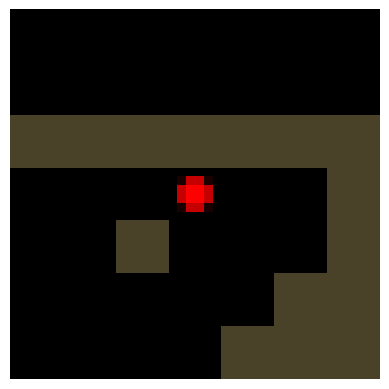

In [ ]:
#| hide
import matplotlib.pyplot as plt
denmormalize = lambda x: x * 0.5 + 0.5
img = denmormalize(sample)
plt.imshow(torch.einsum('chw->hwc', img).numpy())
plt.axis('off')
plt.show()

In [ ]:
#| hide
batch['agent_0']['msg'][0, 0, :, :, :].shape

torch.Size([7, 7, 5])

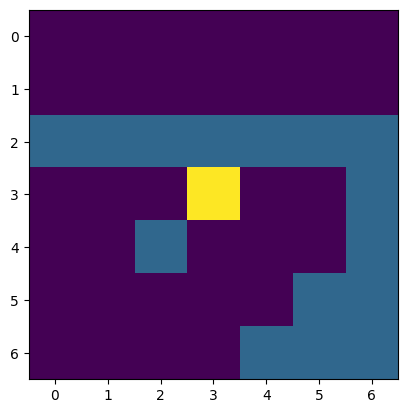

In [ ]:
#| hide
import matplotlib.pyplot as plt
plt.imshow(batch['agent_0']['msg'][0, 0, :, :, :].numpy().argmax(axis=-1))
plt.show()

### Various utils

In [ ]:
#| export
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch
import einops
def show_batch(dl, denormalize_tf, save_to="./batch.png"):
    dataiter = iter(dl)
    data = next(dataiter)
    images = data['agent_0']['obs']

    if images.ndim == 5:
        images = einops.rearrange(images, 'b s c h w -> (b s) c h w')
        print(images.shape)

    print(f"Max pixel value: {images.max().item()}")
    print(f"Mean pixel value: {images.mean().item()}")
    images = denormalize_tf(images) if denormalize_tf is not None else images
    print(f"After denormalization:")
    print("+"*20)
    print(f"Max pixel value: {images.max().item()}")
    print(f"Mean pixel value: {images.mean().item()}")
    images = torch.clamp(images, 0, 1)

    grid_img = torchvision.utils.make_grid(images, nrow=8) # nrow controls how many images per row
    np_grid = torch.einsum('chw->hwc', grid_img).numpy()


    plt.figure(figsize=(15, 10))
    plt.imshow(np_grid)
    plt.axis('off')
    plt.savefig(save_to, bbox_inches='tight')
    plt.savefig("pdf.pdf", bbox_inches='tight')
    plt.show()

torch.Size([40, 3, 42, 42])
Max pixel value: 1.0
Mean pixel value: -0.8795627355575562
After denormalization:
++++++++++++++++++++
Max pixel value: 1.0
Mean pixel value: 0.060218606144189835


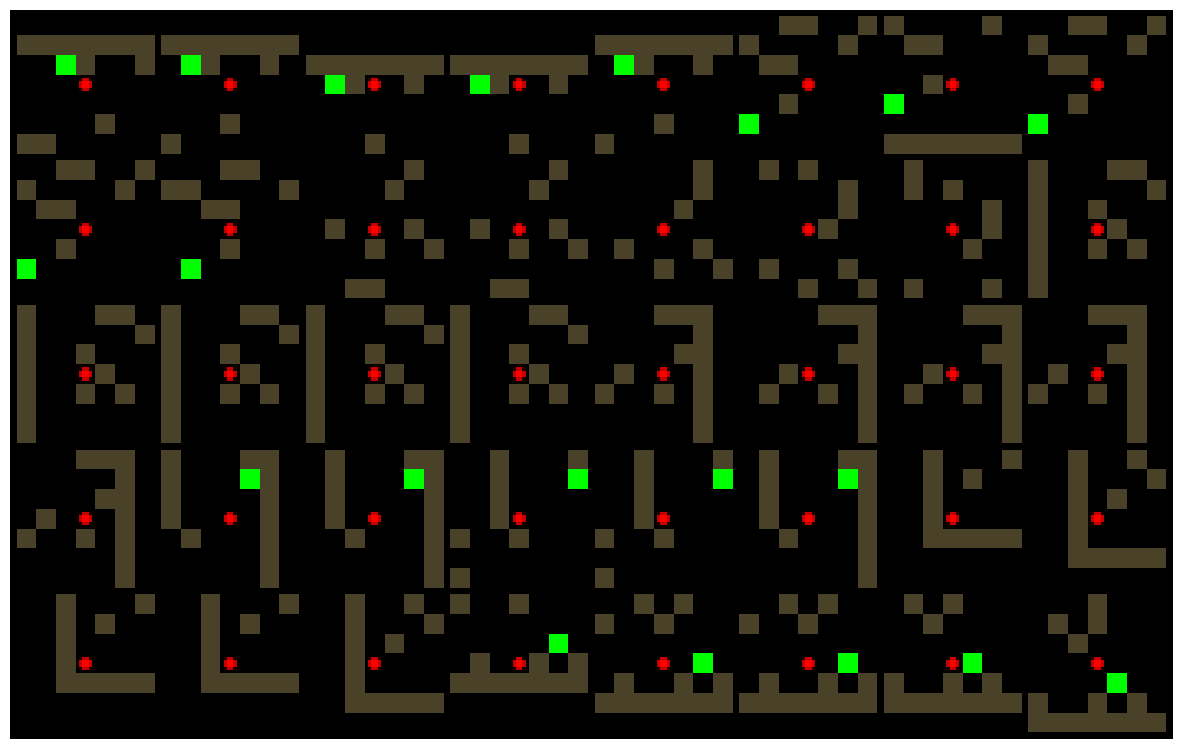

In [ ]:
#| hide
show_batch(dl, denormalize_tf, save_to="../batch.png")

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()